In [208]:
import librosa
import soundfile
import os, glob
import numpy as np
import soundfile
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Conv1D, BatchNormalization, Activation, MaxPooling2D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from IPython.display import Audio
import tensorflow as tf

Data Augmentation

In [230]:
def extract(filepath, mfcc, chroma, mel):
    try:
        y,sr = librosa.load(filepath, duration=2.5, offset=0.5)
        #sample_rate=22050
        result = np.array([])
        stft = np.abs(librosa.stft(y))
        if mfcc:
            mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfcc))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
            result = np.hstack((result, mel))
        return result
    
    except Exception as e:
        print(f"Error processing {filepath}:e")
        return np.array([])

emotions = {
    "01":"neutral",
    "02":"calm",
    "03":'happy',
    "04":"sad",
    "05":'angry',
    '06':'fearful',
    '07':'disgust',
    "08":'surprised'
}

observed_emotions = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']


In [231]:
def load_data(test_size=0.25):
    x,y1 = [],[]
    for file in glob.glob("Actor_*/*.wav"):
        filename = os.path.basename(file)
        emotion = emotions[filename.split("-")[2]]
        if emotion not in observed_emotions:
            continue

        feature = extract(file, mfcc=True, chroma=True, mel=True)        
        x.append(feature)
        y1.append(emotion)
    return train_test_split(np.array(x),y1, test_size=test_size, random_state=9)

In [218]:
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [268]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)
    return x

In [269]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

In [270]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, 3)
    conv_2 = Convolution(conv_1, 128, 5)
    conv_3 = Convolution(conv_2, 512, 3)
    conv_4 = Convolution(conv_3, 512, 3)
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1, 256)
    dense_3 = Dense_f(dense_2, 512)
    
    output = Dense(8, activation="softmax")(dense_3)
    model = Model(inputs=[inputs], outputs=[output])
    opt = Adam(learning_rate=0.001)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt, metrics=["accuracy"])
    
    return model

In [271]:
model = model_fer((180,1))
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 180, 1)]          0         
                                                                 
 conv1d_94 (Conv1D)          (None, 180, 64)           256       
                                                                 
 batch_normalization_159 (B  (None, 180, 64)           256       
 atchNormalization)                                              
                                                                 
 activation_159 (Activation  (None, 180, 64)           0         
 )                                                               
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 90, 64)            0         
 ng1D)                                                           
                                                          

In [272]:
checkpoint = ModelCheckpoint("model_weights3.h5", monitor="val_accuracy", save_weights_only=True, mode="max", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.00001)
callbacks = [checkpoint]
x_train.shape

(1080, 180)

In [273]:
encoder = OneHotEncoder()
df = pd.DataFrame({"Y":y_train})
y_train_encoded = encoder.fit_transform(df[["Y"]]).toarray()
df1 = pd.DataFrame({"Y":y_test})
y_test_encoded = encoder.fit_transform(df1[["Y"]]).toarray()
y_train_encoded.shape

(1080, 8)

In [274]:
print(x_train.shape)
print(y_train_encoded.shape)
print(x_test.shape)
print(y_test_encoded.shape)

(1080, 180)
(1080, 8)
(360, 180)
(360, 8)


In [275]:
history = model.fit(
x=x_train,
y=y_train_encoded,
epochs=200,
batch_size = 45, #try 90 or 45
validation_data = (x_test, y_test_encoded),
callbacks = callbacks
)

Epoch 1/200
24/24 [==============================] - ETA: 0s - loss: 2.3264 - accuracy: 0.1954
Epoch 1: saving model to model_weights3.h5
24/24 [==============================] - 13s 261ms/step - loss: 2.3264 - accuracy: 0.1954 - val_loss: 8.0844 - val_accuracy: 0.1278
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 2.1090 - accuracy: 0.2296
Epoch 2: saving model to model_weights3.h5
24/24 [==============================] - 6s 237ms/step - loss: 2.1090 - accuracy: 0.2296 - val_loss: 4.8024 - val_accuracy: 0.1500
Epoch 3/200
24/24 [==============================] - ETA: 0s - loss: 2.0529 - accuracy: 0.2250
Epoch 3: saving model to model_weights3.h5
24/24 [==============================] - 5s 229ms/step - loss: 2.0529 - accuracy: 0.2250 - val_loss: 3.7090 - val_accuracy: 0.1667
Epoch 4/200
24/24 [==============================] - ETA: 0s - loss: 1.9760 - accuracy: 0.2704
Epoch 4: saving model to model_weights3.h5
24/24 [==============================] - 5s 228ms/step

24/24 [==============================] - ETA: 0s - loss: 1.4750 - accuracy: 0.4380
Epoch 31: saving model to model_weights3.h5
24/24 [==============================] - 6s 231ms/step - loss: 1.4750 - accuracy: 0.4380 - val_loss: 1.5724 - val_accuracy: 0.3972
Epoch 32/200
24/24 [==============================] - ETA: 0s - loss: 1.4734 - accuracy: 0.4370
Epoch 32: saving model to model_weights3.h5
24/24 [==============================] - 6s 234ms/step - loss: 1.4734 - accuracy: 0.4370 - val_loss: 1.5474 - val_accuracy: 0.4250
Epoch 33/200
24/24 [==============================] - ETA: 0s - loss: 1.4283 - accuracy: 0.4639
Epoch 33: saving model to model_weights3.h5
24/24 [==============================] - 6s 239ms/step - loss: 1.4283 - accuracy: 0.4639 - val_loss: 1.5719 - val_accuracy: 0.4222
Epoch 34/200
24/24 [==============================] - ETA: 0s - loss: 1.4813 - accuracy: 0.4593
Epoch 34: saving model to model_weights3.h5
24/24 [==============================] - 5s 225ms/step - los

24/24 [==============================] - ETA: 0s - loss: 1.0418 - accuracy: 0.6296
Epoch 61: saving model to model_weights3.h5
24/24 [==============================] - 5s 228ms/step - loss: 1.0418 - accuracy: 0.6296 - val_loss: 1.9303 - val_accuracy: 0.3250
Epoch 62/200
24/24 [==============================] - ETA: 0s - loss: 1.0483 - accuracy: 0.6065
Epoch 62: saving model to model_weights3.h5
24/24 [==============================] - 6s 241ms/step - loss: 1.0483 - accuracy: 0.6065 - val_loss: 1.7216 - val_accuracy: 0.4306
Epoch 63/200
24/24 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.6157
Epoch 63: saving model to model_weights3.h5
24/24 [==============================] - 6s 236ms/step - loss: 1.0192 - accuracy: 0.6157 - val_loss: 1.4081 - val_accuracy: 0.4722
Epoch 64/200
24/24 [==============================] - ETA: 0s - loss: 1.0729 - accuracy: 0.6111
Epoch 64: saving model to model_weights3.h5
24/24 [==============================] - 6s 244ms/step - los

24/24 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7833
Epoch 91: saving model to model_weights3.h5
24/24 [==============================] - 5s 224ms/step - loss: 0.5989 - accuracy: 0.7833 - val_loss: 1.4785 - val_accuracy: 0.5278
Epoch 92/200
24/24 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.7741
Epoch 92: saving model to model_weights3.h5
24/24 [==============================] - 5s 225ms/step - loss: 0.6031 - accuracy: 0.7741 - val_loss: 1.4498 - val_accuracy: 0.5417
Epoch 93/200
24/24 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.7833
Epoch 93: saving model to model_weights3.h5
24/24 [==============================] - 5s 228ms/step - loss: 0.6001 - accuracy: 0.7833 - val_loss: 1.4718 - val_accuracy: 0.5528
Epoch 94/200
24/24 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7639
Epoch 94: saving model to model_weights3.h5
24/24 [==============================] - 5s 221ms/step - los

24/24 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8593
Epoch 121: saving model to model_weights3.h5
24/24 [==============================] - 5s 227ms/step - loss: 0.3973 - accuracy: 0.8593 - val_loss: 1.5746 - val_accuracy: 0.5639
Epoch 122/200
24/24 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8787
Epoch 122: saving model to model_weights3.h5
24/24 [==============================] - 5s 227ms/step - loss: 0.3441 - accuracy: 0.8787 - val_loss: 1.6327 - val_accuracy: 0.5583
Epoch 123/200
24/24 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8806
Epoch 123: saving model to model_weights3.h5
24/24 [==============================] - 5s 226ms/step - loss: 0.3593 - accuracy: 0.8806 - val_loss: 1.5228 - val_accuracy: 0.5667
Epoch 124/200
24/24 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.8722
Epoch 124: saving model to model_weights3.h5
24/24 [==============================] - 5s 221ms/ste

24/24 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9204
Epoch 151: saving model to model_weights3.h5
24/24 [==============================] - 6s 233ms/step - loss: 0.2349 - accuracy: 0.9204 - val_loss: 1.6077 - val_accuracy: 0.6056
Epoch 152/200
24/24 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9194
Epoch 152: saving model to model_weights3.h5
24/24 [==============================] - 5s 227ms/step - loss: 0.2312 - accuracy: 0.9194 - val_loss: 1.4350 - val_accuracy: 0.6250
Epoch 153/200
24/24 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9241
Epoch 153: saving model to model_weights3.h5
24/24 [==============================] - 6s 232ms/step - loss: 0.2070 - accuracy: 0.9241 - val_loss: 1.5641 - val_accuracy: 0.6139
Epoch 154/200
24/24 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9389
Epoch 154: saving model to model_weights3.h5
24/24 [==============================] - 5s 231ms/ste

24/24 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9565
Epoch 181: saving model to model_weights3.h5
24/24 [==============================] - 5s 226ms/step - loss: 0.1392 - accuracy: 0.9565 - val_loss: 1.6056 - val_accuracy: 0.6028
Epoch 182/200
24/24 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9500
Epoch 182: saving model to model_weights3.h5
24/24 [==============================] - 5s 224ms/step - loss: 0.1486 - accuracy: 0.9500 - val_loss: 1.5501 - val_accuracy: 0.6417
Epoch 183/200
24/24 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9481
Epoch 183: saving model to model_weights3.h5
24/24 [==============================] - 6s 239ms/step - loss: 0.1521 - accuracy: 0.9481 - val_loss: 1.5894 - val_accuracy: 0.6167
Epoch 184/200
24/24 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9463
Epoch 184: saving model to model_weights3.h5
24/24 [==============================] - 5s 229ms/ste

In [276]:
model.evaluate(x_test, y_test_encoded)

12/12 [==============================] - 1s 33ms/step - loss: 1.5640 - accuracy: 0.6306


[1.5639829635620117, 0.6305555701255798]

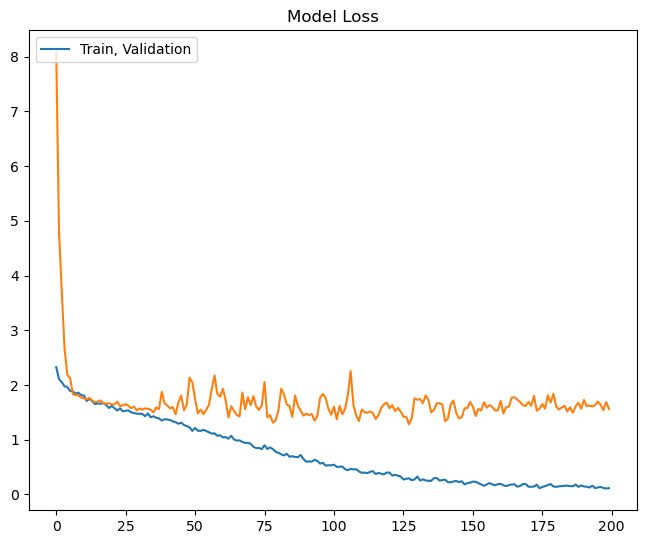

In [277]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train, Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

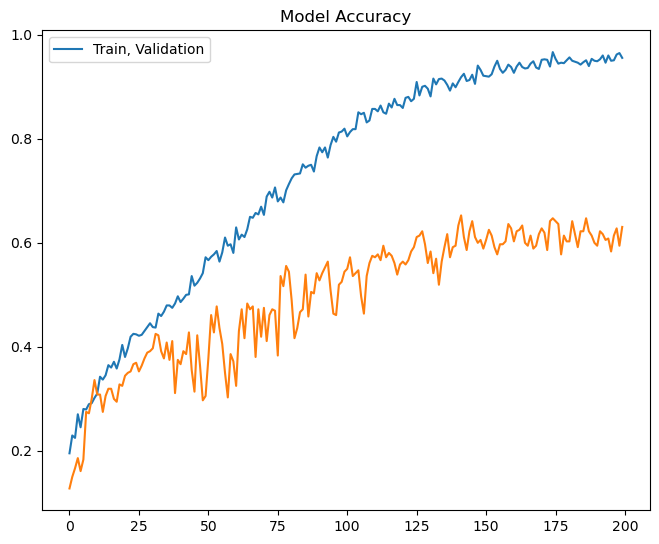

In [278]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train, Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

In [279]:
model_json = model.to_json()
with open("model_a1.json","w") as json_file:
    json_file.write(model_json)